# ELE510 Project - Hand Gesture Detection

## Imports

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import codecs
import json
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
# Hide GPU due to small model
tf.config.set_visible_devices([], 'GPU')

## Loading and testing data

Each image has a an annotation. The annotation consists of the fields: `bboxes`, `labels`, `landmarks`, `leading_conf`, `leading_hand`, and `user_id`. <br>
<br>
bboxes - Normalized coordinates for boxes around detected hands. `[top left X pos, top left Y pos, width, height]`. <br>
labels - List of class labels of the detected gestures. e.g. `like`, `peace`, `no_gesture`. <br>
landmarks - List of normalized hand landmarks `[x, y]`. <br>
leading_conf - Leading confidence for `leading_hand`.  <br>
leading_hand - `right` or `left` for hand which showing gesture. <br>
user_id - subject id.

In [2]:
# Adding all annotation files to a list
files = []
for file in os.listdir("data"):
    if file.endswith(".json"):
        files.append(os.path.join("data", file))
        
# Exporting json data from file to dictionary
class_names = [
       'call',
       'dislike',
       'fist',
       'four',
       'like',
       'mute',
       'ok',
       'one',
       'palm',
       'peace',
       'peace_inverted',
       'rock',
       'stop',
       'stop_inverted',
       'three',
       'three2',
       'two_up',
       'two_up_inverted']

data = {}

classindex = 0
for file in files:
    current_class = class_names[classindex]
    class_annotations = {}
    with codecs.open(file,'r','utf-8') as f: 
        annotations = json.load(f)
        for annotation in annotations:
            class_annotations[annotation] = annotations[annotation]
    classindex += 1
    data[current_class] = class_annotations

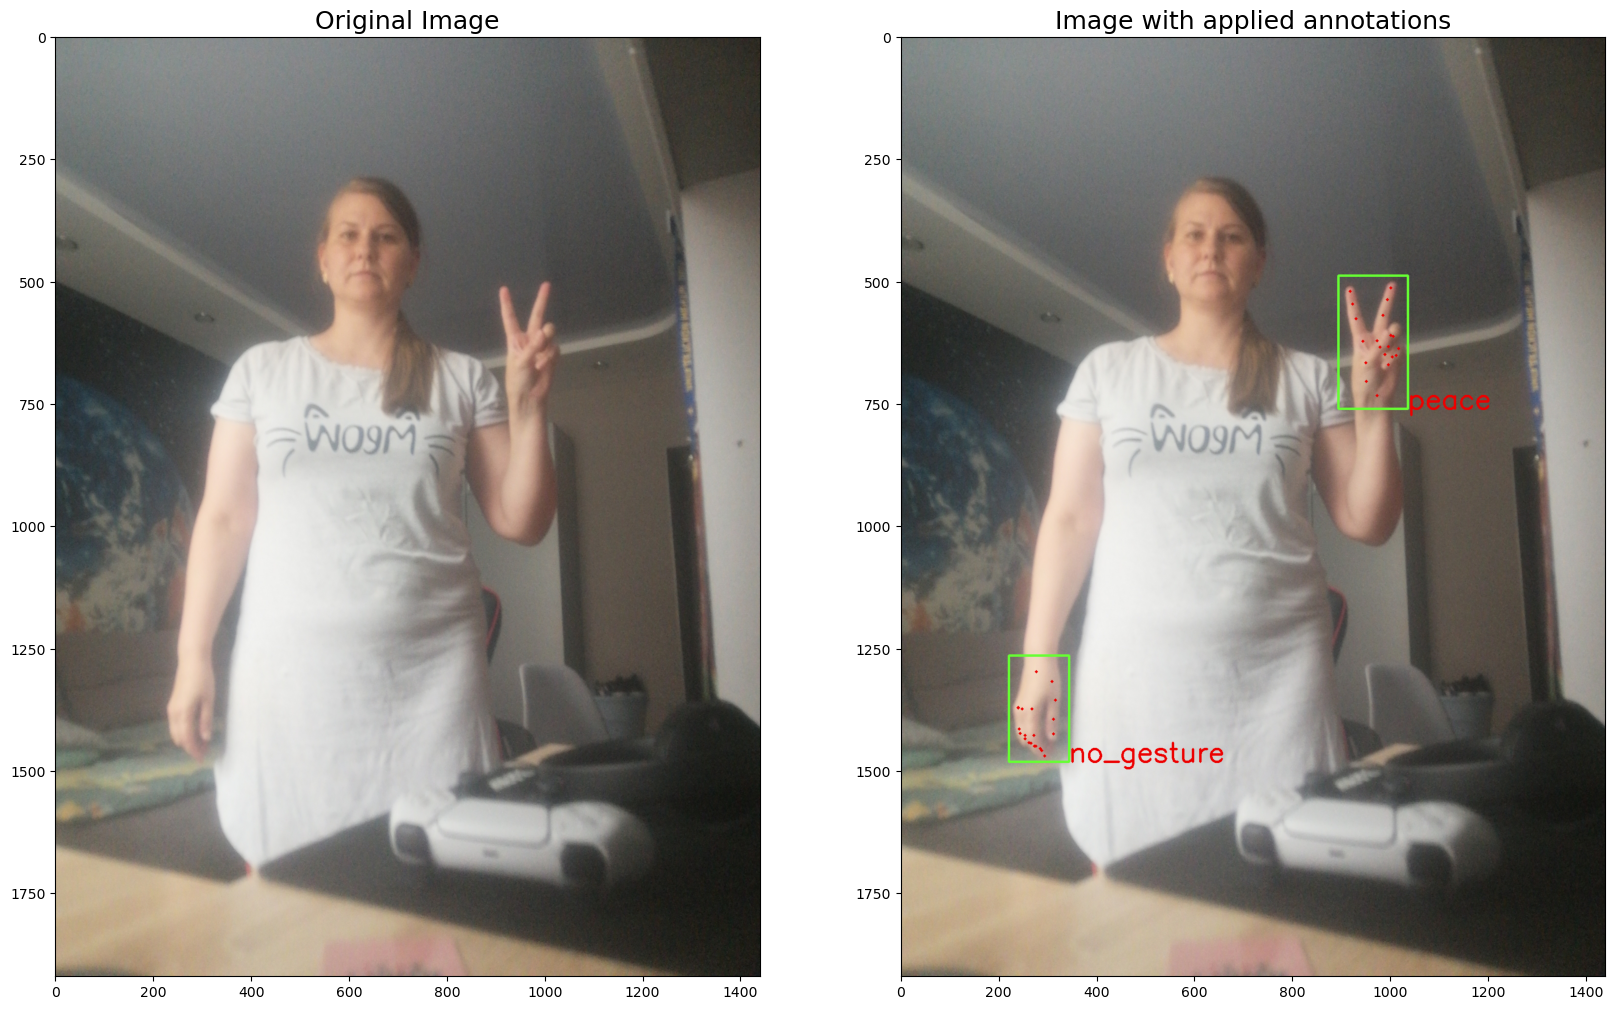

In [5]:
# Testing data in RGB format
image_name = '046a2bea-e479-4ec2-9fa9-05d5a1e96755'
im = cv2.imread('images/original/peace/' + image_name + '.jpg')[...,::-1]

# Applying image annotations
im_ann = im.copy()
im_data = data['peace'][image_name]
h, w = im_ann.shape[0], im_ann.shape[1]
iteration = 0
for bbox in im_data['bboxes']:
    start_point = (int(w*bbox[0]) , int(h*bbox[1]))
    end_point = (int(start_point[0]+(w*bbox[2])), int(start_point[1]+(h*bbox[3])))
    im_ann = cv2.rectangle(im_ann, start_point, end_point, color = (102,255,51), thickness = 3)
    cv2.putText(im_ann, im_data['labels'][iteration], (end_point[0], end_point[1]), cv2.FONT_HERSHEY_SIMPLEX, w / 780, (237, 0, 0), 3)
    iteration += 1

for landmark in im_data['landmarks']:
    for coordinate in landmark:
        im_ann = cv2.circle(im_ann, (int(w*coordinate[0]), int(h*coordinate[1])), radius=1, color=(237, 0, 0), thickness=3)
    
# Plot images
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.title('Original Image', fontsize=18)
plt.imshow(im)
plt.subplot(122)
plt.title('Image with applied annotations', fontsize=18)
plt.imshow(im_ann)
plt.show()

## Image preprocessing

When having a small dataset the model will sometimes learn from noises or unwanted details from training examples, to an extent that it negatively impacts the performance of the model on new examples. Also known as overfitting. To avoid this we would normally preprocess the images. <br> 
<br>
Preprocessing steps:
1. Create a depth map of the image. <br>
2. Use depth thresholding and remove noise to localize hand in depth map. <br>
3. Resize the hand segment according to the model input size. <br>
<br>
For this dataset the preprocessing is already done in the annotation files. We create new images out of the areas inside `bboxes` for training the model.

In [26]:
# Defining height and width for new images as well as input for the model
img_height = 300
img_width = 300

# Crop and resize images
for category in class_names:
    for img_name in data[category]:
        im = cv2.imread('images/original/' + category + '/' + img_name + '.jpg')[...,::-1]
        h, w = im.shape[0], im.shape[1]
        iteration = 0
        for bbox in data[category][img_name]['bboxes']:
            start_point = (int(w*bbox[0]) , int(h*bbox[1]))
            end_point = (int(start_point[0]+(w*bbox[2])), int(start_point[1]+(h*bbox[3])))
            cropped_image = im[start_point[1]:end_point[1], start_point[0]:end_point[0]]
            resized_image = cv2.resize(cropped_image, (img_height, img_width), interpolation= cv2.INTER_LINEAR)
            label = data[category][img_name]['labels'][iteration]
            cv2.imwrite('images/preprocessed/' + label + '/' + img_name + '.jpg' , resized_image[...,::-1])
            iteration += 1

In [4]:
# Preprocessed image from example above
cropped_im_1 = cv2.imread('images/preprocessed/peace/' + image_name + '.jpg')[...,::-1]
cropped_im_2 = cv2.imread('images/preprocessed/no_gesture/' + image_name + '.jpg')[...,::-1]

plt.figure(figsize=(20,20))
plt.subplot(121)
plt.title('Cropped and resized peace gesture', fontsize=18)
plt.imshow(cropped_im_1)
plt.subplot(122)
plt.title('Cropped and resized no_gesture', fontsize=18)
plt.imshow(cropped_im_2)
plt.show()

TypeError: 'NoneType' object is not subscriptable

## Create train and validation dataset using the 80/20 split

In [6]:
# Defining parameters for loader
img_height = 300
img_width = 300
batch_size = 32

# Creating train dataset
train_data = tf.keras.utils.image_dataset_from_directory(
  'images/preprocessed',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Creating test dataset
validation_data = tf.keras.utils.image_dataset_from_directory(
  'images/preprocessed',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1800 files belonging to 18 classes.
Using 1440 files for training.
Found 1800 files belonging to 18 classes.
Using 360 files for validation.


## Create and compile model

In [7]:
# Creating model
num_classes = len(validation_data.class_names)

# Data augmentation to replicate more data
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    ])

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

# Compiling model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 300, 300, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                  

## Train model

In [8]:
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_data = validation_data.cache().prefetch(buffer_size=AUTOTUNE)

epochs = 30
history = model.fit(train_data, validation_data=validation_data, epochs=epochs)

Epoch 1/30
45/45 [==============================] - 77s 2s/step - loss: 3.2334 - accuracy: 0.0542 - val_loss: 2.8911 - val_accuracy: 0.0472
Epoch 2/30
45/45 [==============================] - 64s 1s/step - loss: 2.8828 - accuracy: 0.0653 - val_loss: 2.8839 - val_accuracy: 0.0833
Epoch 3/30
45/45 [==============================] - 61s 1s/step - loss: 2.8302 - accuracy: 0.0903 - val_loss: 2.8114 - val_accuracy: 0.1472
Epoch 4/30
45/45 [==============================] - 69s 2s/step - loss: 2.7957 - accuracy: 0.1299 - val_loss: 2.7568 - val_accuracy: 0.1556
Epoch 5/30
45/45 [==============================] - 65s 1s/step - loss: 2.6750 - accuracy: 0.1736 - val_loss: 2.5088 - val_accuracy: 0.2472
Epoch 6/30
45/45 [==============================] - 63s 1s/step - loss: 2.5112 - accuracy: 0.2326 - val_loss: 2.3598 - val_accuracy: 0.2611
Epoch 7/30
45/45 [==============================] - 77s 2s/step - loss: 2.3146 - accuracy: 0.2847 - val_loss: 2.1419 - val_accuracy: 0.3306
Epoch 8/30
45/45 [==

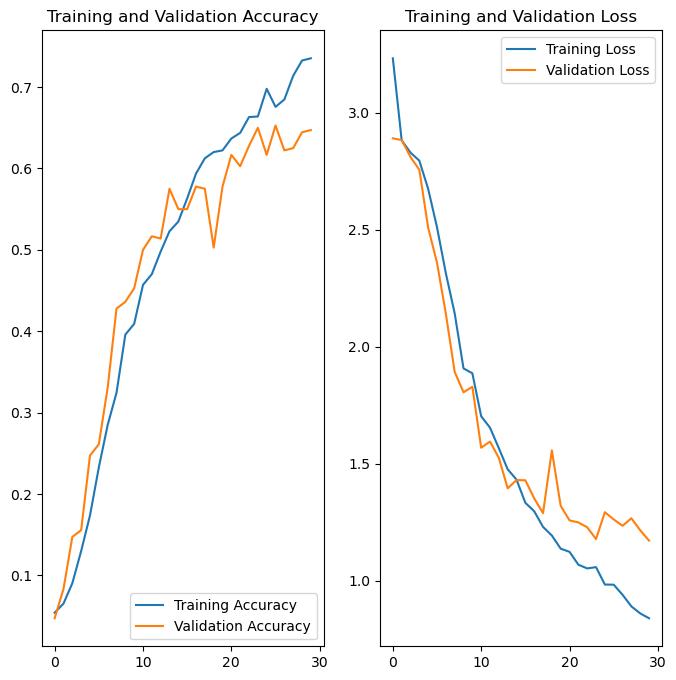

In [9]:
# Vizualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Save model
model.save('tf_model/')

## Test model

In [2]:
# Load model
model = keras.models.load_model('tf_model')

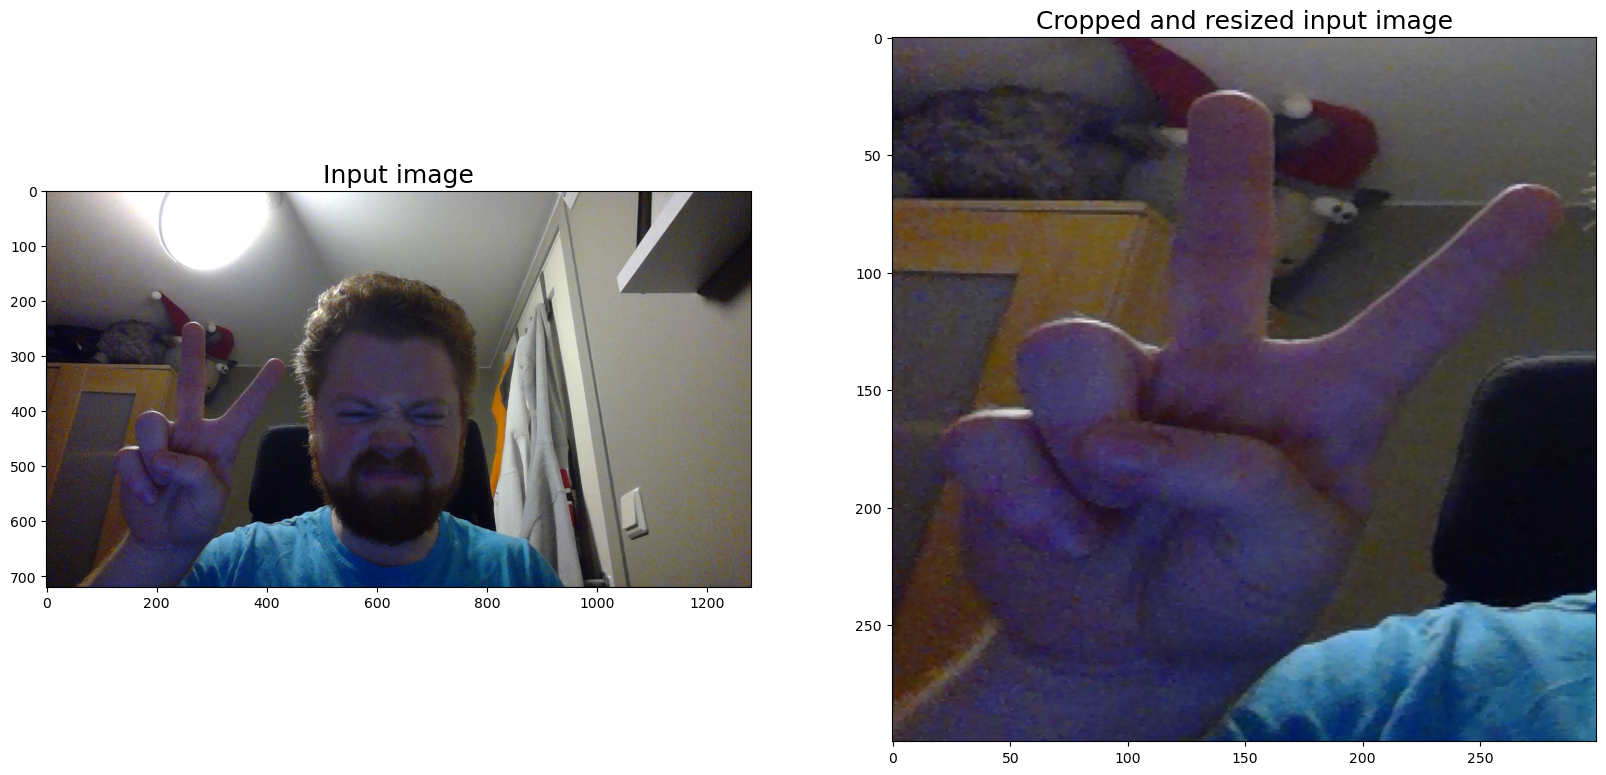

In [25]:
# Preprocess input image
input_image = cv2.imread('test.jpg')[...,::-1]
cropped_input_image = input_image[200:700, 100:450]
cropped_input_image = cv2.resize(cropped_input_image, (300, 300), interpolation= cv2.INTER_LINEAR)

cv2.imwrite('test_crop.jpg', cropped_input_image[...,::-1])

plt.figure(figsize=(20,20))
plt.subplot(121)
plt.title('Input image', fontsize=18)
plt.imshow(input_image)
plt.subplot(122)
plt.title('Cropped and resized input image', fontsize=18)
plt.imshow(cropped_input_image)
plt.show()

In [48]:
# Test the input image
img = tf.keras.utils.load_img('test_crop.jpg', target_size=(300, 300))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
class_names = train_data.class_names

# Prediction table
for x in range(len(class_names)):
    print(class_names[x] + ': Prediction: '+ str(predictions[0][x]) + ' - Score: ' +  str(score[x]))


print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 58ms/step
call: Prediction: 3.7764826 - Score: tf.Tensor(0.22524482, shape=(), dtype=float32)
dislike: Prediction: -1.3510034 - Score: tf.Tensor(0.0013360295, shape=(), dtype=float32)
fist: Prediction: -5.8113947 - Score: tf.Tensor(1.5441605e-05, shape=(), dtype=float32)
four: Prediction: -0.4691834 - Score: tf.Tensor(0.0032269, shape=(), dtype=float32)
like: Prediction: 0.88454753 - Score: tf.Tensor(0.012494054, shape=(), dtype=float32)
mute: Prediction: 1.9229487 - Score: tf.Tensor(0.035291925, shape=(), dtype=float32)
ok: Prediction: 4.3690114 - Score: tf.Tensor(0.40736791, shape=(), dtype=float32)
one: Prediction: 0.42894194 - Score: tf.Tensor(0.007922029, shape=(), dtype=float32)
palm: Prediction: 2.5135179 - Score: tf.Tensor(0.063702464, shape=(), dtype=float32)
peace: Prediction: 1.9581904 - Score: tf.Tensor(0.036557842, shape=(), dtype=float32)
peace_inverted: Prediction: 0.16837472 - Score: tf.Tensor(0.006104828, shape=(), dtype=float3